In [50]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import src.cp_hw2

# Noise calibration

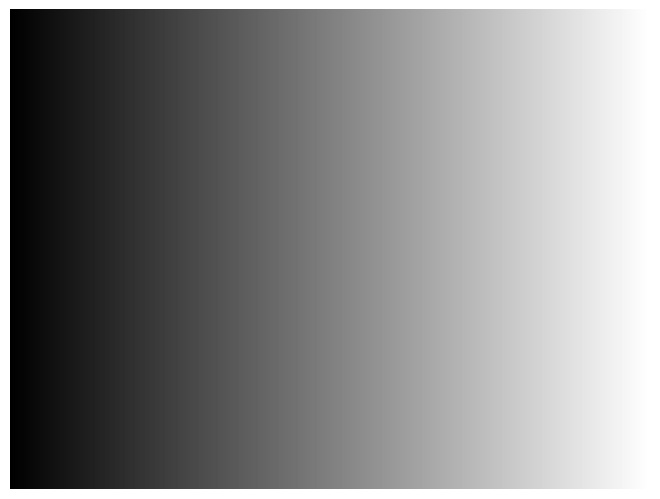

In [52]:
fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(np.tile(np.linspace(0, 1, 255*16), (255*12,1)), cmap='gray', aspect='auto')
# fig.savefig('ramp_pattern.jpeg',dpi=2400)

In [53]:
img_sum = None

num_images = 50

# Generate the list of paths
path_list = ['data/noise_cal/dark_'+str(i)+'.tiff' for i in range(1, num_images + 1)]

for path in path_list:
    img = cv2.imread(path, -1)
    
    # Convert color from BGR to RGB
    img = img[..., ::-1]
    
    # Downsample
    img = img[::5, ::5]
    
    # Initialize img_sum if it's None
    if img_sum is None:
        img_sum = np.zeros_like(img, dtype=np.float64)
    
    img_sum += img

# Compute the average image (dark frame)
dark_frame = img_sum / num_images

dark_frame = dark_frame.astype(np.uint16)

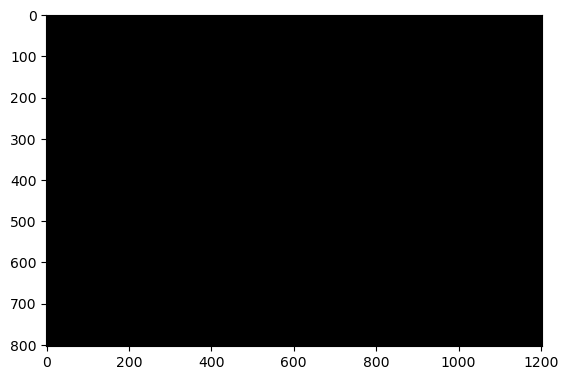

In [54]:
plt.imshow(dark_frame/ (2**16 - 1))

In [55]:
img_sum = None
num_images = 50

# Generate the list of paths
path_list = ['data/noise_cal/ramp_pattern'+str(i)+'.tiff' for i in range(1, num_images + 1)]

imgs_ramp = []
for path in path_list:
    img = cv2.imread(path, -1)
    
    # Convert color from BGR to RGB
    img = img[..., ::-1]
    
    # Downsample the image
    img = img[::5, ::5]

    # subtract dark frame
    img = img - dark_frame

    imgs_ramp.append(img)

imgs_ramp = np.array(imgs_ramp)

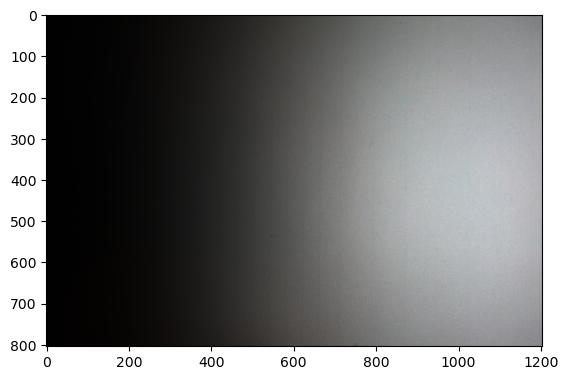

In [34]:
plt.imshow(imgs_ramp[0]/ (2**16 - 1))

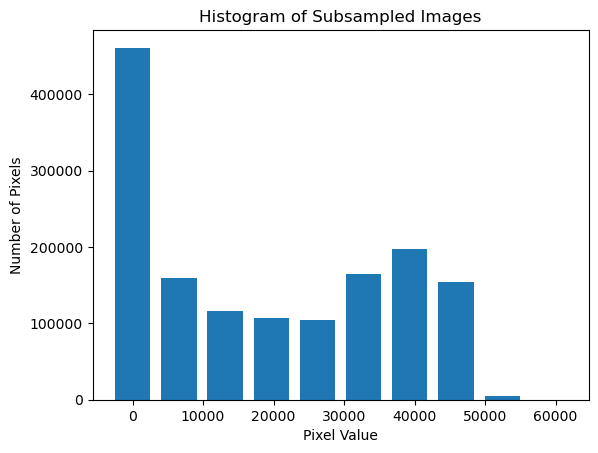

In [35]:
img_sampled = []

for img in imgs_ramp:
    # Subsample the image by taking every 10th pixel in both rows and columns
    subsampled_img = img[::10, ::10]
    # Append the subsampled image to the list
    img_sampled.append(subsampled_img)

# Convert the list of subsampled images to a NumPy array
img_sampled = np.array(img_sampled)

# Compute the histogram of the subsampled images
H, bins = np.histogram(img_sampled)

# Plot the histogram
plt.bar(bins[:-1], H, width=5000)  # Setting the bar width to 5000
plt.xlabel('Pixel Value')  # Label for the x-axis
plt.ylabel('Number of Pixels')  # Label for the y-axis
plt.title('Histogram of Subsampled Images')  # Title for the plot
plt.show()


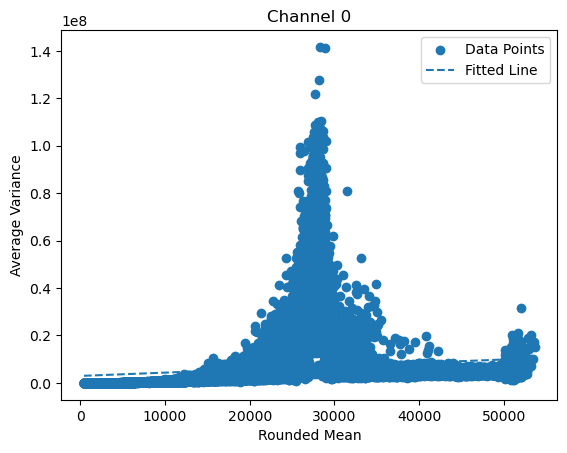

For channel 0:
Estimated camera gain (g): 138.31875187630737
Estimated total additive noise variance (sigma^2): 2956190.749379316


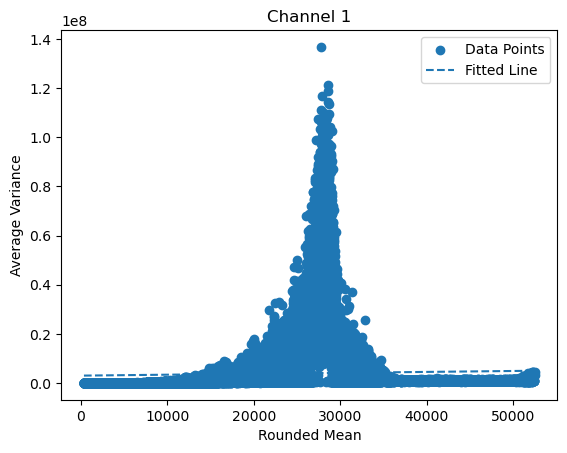

For channel 1:
Estimated camera gain (g): 37.82269262925981
Estimated total additive noise variance (sigma^2): 2971044.0422963495


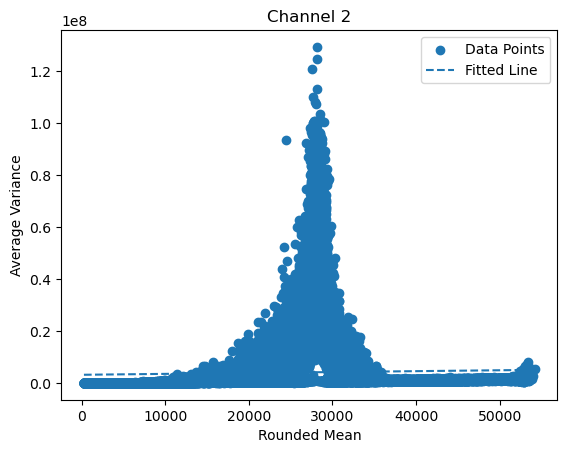

For channel 2:
Estimated camera gain (g): 34.87946758882906
Estimated total additive noise variance (sigma^2): 3135464.711302983


In [36]:
from scipy.optimize import curve_fit

# linear function for curve fitting
def linear_func(x, a, b):
    return a * x + b

g_list = []
sigma_squared_list = []

# Loop through each color channel
for channel in range(imgs_ramp.shape[-1]):
    # initialize lists for each channel
    unique_means = []
    avg_variances = []
    
    # Calculate the mean and variance for each pixel across all images in this channel
    means = np.mean(imgs_ramp[..., channel], axis=0)
    variances = np.var(imgs_ramp[..., channel], axis=0)

    # Round the means to the nearest integer
    rounded_means = np.round(means).astype(int)

    # Find unique rounded means and calculate the average variance for each
    for unique_mean in np.unique(rounded_means):
        mask = (rounded_means == unique_mean)
        avg_variance = np.mean(variances[mask])
        
        unique_means.append(unique_mean)
        avg_variances.append(avg_variance)

    # Convert lists to numpy arrays for easier manipulation
    unique_means = np.array(unique_means)
    avg_variances = np.array(avg_variances)
    
    # Fit a line to the mean-variance points
    params, _ = curve_fit(linear_func, unique_means, avg_variances)

    # Extract the camera gain (g) and total additive noise variance (sigma^2)
    g, sigma_squared = params

    # Plot the mean-variance relationship and the fitted line
    plt.scatter(unique_means, avg_variances, label='Data Points')
    plt.plot(unique_means, linear_func(unique_means, *params), label='Fitted Line', linestyle='--')
    plt.xlabel('Rounded Mean')
    plt.ylabel('Average Variance')
    plt.title(f'Channel {channel}')
    plt.legend()
    plt.show()

    print(f"For channel {channel}:")
    print(f"Estimated camera gain (g): {g}")
    print(f"Estimated total additive noise variance (sigma^2): {sigma_squared}")
    
    g_list.append(g)
    sigma_squared_list.append(sigma_squared)


# Merging with optimal weights

In [37]:
# Function to calculate exposure times
exptime = lambda x: 2.0 ** (x - 1 - 11)
exptime_list = [exptime(i) for i in range(1, 17)]

print(f"Exposure times: {exptime_list}")

Exposure times: [0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0]


In [38]:
def subtrack_dark(images_stack_tiff, dark_frame, exptime_list) :
    t_nc = 1/4
    
    images_stack_tiff_darkframe_sub = np.zeros(images_stack_tiff.shape)
    
    for k in range(len(images_stack_tiff)) :
    
        images_stack_tiff_darkframe_sub[k] = images_stack_tiff[k] - ((exptime_list[k]/t_nc) * dark_frame) 
    
    return images_stack_tiff_darkframe_sub

# Load my tiff images
path_list = ['data/my_stack/exposure'+str(i)+'.tiff' for i in range(1,17)]
imgs_stack_tiff = []
for path in path_list :
    img = cv2.imread(path, -1)
    img = img[...,::-1]
    img = img[::5, ::5]
    imgs_stack_tiff.append(img)
imgs_stack_tiff = np.array(imgs_stack_tiff)
images_stack_tiff_darkframe_sub = subtrack_dark(imgs_stack_tiff, dark_frame, exptime_list) 

# Normalize the images
images_stack_tiff_normalized = images_stack_tiff_darkframe_sub / (2**16 - 1)


In [45]:
def linear_merging(img_stack, img_stack_linear, exptime_list, weight_vector, g, var_add) :
    
    img_hdr_num = np.zeros(img_stack[0].shape)
    img_hdr_den = np.zeros(img_stack[0].shape)
    
    for k in range(len(img_stack)) :
        w_v_imk = weight_vector(img_stack[k], exptime_list[k], g, var_add, 0.00005, 0.95)
        img_hdr_num += (w_v_imk * img_stack_linear[k] / exptime_list[k] ) 
        img_hdr_den += (w_v_imk)

    
    img_hdr = img_hdr_num / img_hdr_den
    
    # if img_hdr_num == 0, img_hdr should also be zero
    img_hdr_num_zero = np.where(img_hdr_num == 0)
    if len(img_hdr_num_zero) == 3 : 
        img_hdr_num_zero = np.vstack((np.vstack((img_hdr_num_zero[0],img_hdr_num_zero[1])), img_hdr_num_zero[2])).T
    else : 
        img_hdr_num_zero = np.vstack((img_hdr_num_zero[0],img_hdr_num_zero[1])).T
        
    # if only img_hdr_den is zero, img_hdr should be max val
    img_hdr_den_zero = np.where(img_hdr_den == 0)
    if len(img_hdr_den_zero) == 3 : 
        img_hdr_den_zero = np.vstack((np.vstack((img_hdr_den_zero[0],img_hdr_den_zero[1])), img_hdr_den_zero[2])).T
    else : 
        img_hdr_den_zero = np.vstack((img_hdr_den_zero[0],img_hdr_den_zero[1])).T
    
    img_hdr_max_val = []
    
    if img_hdr_num_zero.size > 0 :
        if len(img_hdr.shape) == 3 : 
            img_hdr[img_hdr_num_zero[:,0],img_hdr_num_zero[:,1],img_hdr_num_zero[:,2]] = 0
        else : 
            img_hdr[img_hdr_num_zero[:,0],img_hdr_num_zero[:,1]] = 0
    
    if img_hdr_den_zero.size > 0 :
        for index in img_hdr_den_zero :
            if len(img_hdr.shape) == 3 : 
                if img_hdr_num[index[0],index[1],index[2]] != 0 : 
                    img_hdr_max_val.append(index)
            else : 
                if img_hdr_num[index[0],index[1]] != 0 : 
                    img_hdr_max_val.append(index)
        img_hdr_max_val = np.array(img_hdr_max_val)
        if img_hdr_max_val.size > 0 :
            img_hdr_max_val = np.stack(img_hdr_max_val)
            if len(img_hdr.shape) == 3 : 
                img_hdr[img_hdr_max_val[:,0],img_hdr_max_val[:,1],img_hdr_max_val[:,2]] = np.nanmax(img_hdr)
            else : 
                img_hdr[img_hdr_max_val[:,0],img_hdr_max_val[:,1]] = np.nanmax(img_hdr)
    
    return img_hdr

def linear_merging_channelwise(img_stack, img_stack_linear, exptime_list, weight_vector, g_r, g_m, b_m, var_add_r, var_add_g, var_add_b):
    
    img_hdr = np.zeros(img_stack[0].shape)
    img_hdr[...,0] = linear_merging(img_stack[...,0], img_stack_linear[...,0], exptime_list, weight_vector, g_r, var_add_r) 
    img_hdr[...,1] = linear_merging(img_stack[...,1], img_stack_linear[...,1], exptime_list, weight_vector, g_m, var_add_g) 
    img_hdr[...,2] = linear_merging(img_stack[...,2], img_stack_linear[...,2], exptime_list, weight_vector, b_m, var_add_b) 

    return img_hdr

@np.vectorize
def weight_optimal(z, t_k, g, var_add, Z_min=0.001, Z_max=0.995):
    if Z_min <= z <= Z_max :
        out_num = t_k ** 2
        out_den = g * z + var_add
 
        return out_num / out_den
    
    return 0

# HDR display util functions
def linear_scaling(img, scale):
    img_scaled = np.clip(img * scale, 0, 1)
    return img_scaled

def gamma_encoding(x) : 
    if x <= 0.0031308 : 
        return 12.92 * x
    else : 
        return (1+0.055) * np.power(x, 1/2.4) - 0.055

def display_hdr(img, scale, title='') : 
    img_scaled = linear_scaling(img, scale)
    gamma_encoding_vect = np.vectorize(gamma_encoding)
    image_ge = gamma_encoding_vect(img_scaled)

    plt.imshow(image_ge)
    plt.title(title)
    plt.show()

In [46]:
img_hdr_tiff_lin_merged_w_optimal = linear_merging_channelwise(images_stack_tiff_normalized, images_stack_tiff_darkframe_sub, exptime_list, weight_optimal, g_list[0], g_list[1], g_list[2], sigma_squared_list[0], sigma_squared_list[1], sigma_squared_list[2])

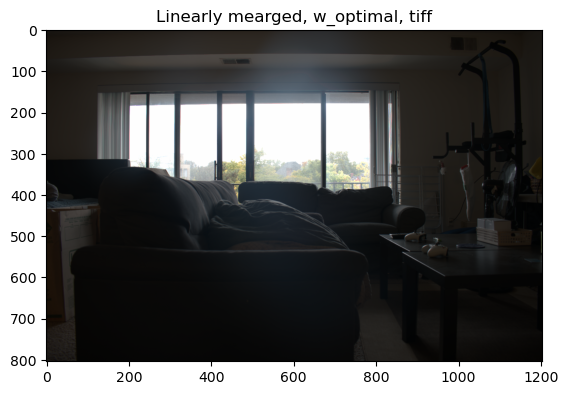

In [47]:
display_hdr(img_hdr_tiff_lin_merged_w_optimal, 0.00001, 'Linearly mearged, w_optimal, tiff')

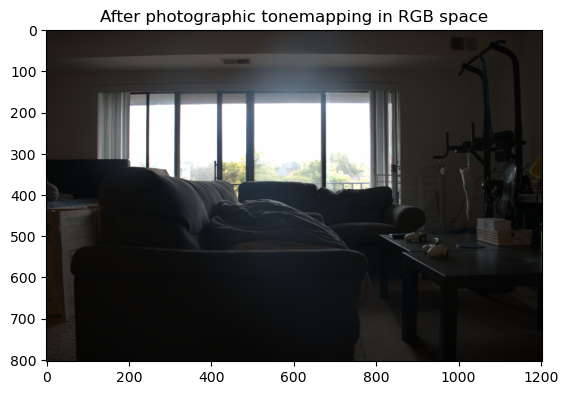

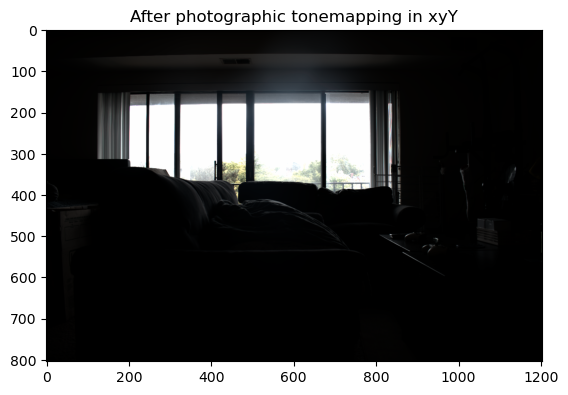

In [48]:
img_hdr_selected = img_hdr_tiff_lin_merged_w_optimal.copy()

# Define functions for tonemapping
def get_I_m_hdr(img) : 
    if img.min() < 0 : 
        # clipping out negative values and raising them to be over 0
        I_m_hdr = np.exp(np.log(img - (1.00000001) * img.min()).mean()) 
    else : 
        # else 
        I_m_hdr = np.exp(np.log(img + 1e5).mean()) 
    
    return I_m_hdr

def get_I_tilda_ij_hdr(I_m_hdr, im, K) : 
    I_tilda_ij_hdr= K * (im) / I_m_hdr
    return I_tilda_ij_hdr

def get_I_tilda_white(I_tilda_ij_hdr, B) : 
    I_tilda_white = B * np.max(I_tilda_ij_hdr)
    return I_tilda_white

def phtographic_tonemapping(img, K, B) :
    
    I_m_hdr = get_I_m_hdr(img)
    I_tilda_ij_hdr = get_I_tilda_ij_hdr(I_m_hdr, img, K)
    I_tilda_white = get_I_tilda_white(I_tilda_ij_hdr, B)
    
    img_tonemapped_num = I_tilda_ij_hdr * (1 + I_tilda_ij_hdr / (I_tilda_white**2))
    img_tonemapped_den = 1 + I_tilda_ij_hdr
    
    img_tonemapped = img_tonemapped_num / img_tonemapped_den
    
    return img_tonemapped

def photographic_tonemapping_xyY(img, K, B) :
    
    img_XYZ = src.cp_hw2.lRGB2XYZ(img)
    x = img_XYZ[...,0] / img_XYZ.sum(2) 
    y = img_XYZ[...,1] / img_XYZ.sum(2)
    Y = img_XYZ[...,1]
    
    Y_tonemapped = phtographic_tonemapping(Y, K, B)
    
    X = (x * Y_tonemapped) / y
    Y = Y_tonemapped
    Z = (1 - x - y) * Y_tonemapped / y
    
    img_XYZ_tonemapped = np.concatenate((np.stack((X,Y),-1),np.expand_dims(Z,-1)),-1)   
    img_RGB_tonemapped = src.cp_hw2.XYZ2lRGB(img_XYZ_tonemapped)
    
    return img_RGB_tonemapped


img_hdr_selected_cc_wb_ptm = phtographic_tonemapping(img_hdr_selected, K=0.09, B=0.95)
display_hdr(img_hdr_selected_cc_wb_ptm, 15, 'After photographic tonemapping in RGB space')


img_hdr_selected_cc_wb_ptm_xyY = photographic_tonemapping_xyY(img_hdr_selected, K=0.18, B=0.01)
display_hdr(img_hdr_selected_cc_wb_ptm_xyY, 0.01, 'After photographic tonemapping in xyY')

In [56]:
src.cp_hw2.writeHDR('output/part5.hdr', img_hdr_selected_cc_wb_ptm)